In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [ ]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '48-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [ ]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [ ]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 15,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 20,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 15,
 'WIDTH': 256}

# Load data

In [ ]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [ ]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'])
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'])
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [ ]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 15. * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = 5. * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = 25. * tf.random.normal([1],dtype='float32') 
    width_shift = 25. * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000298 to 7.27e-06


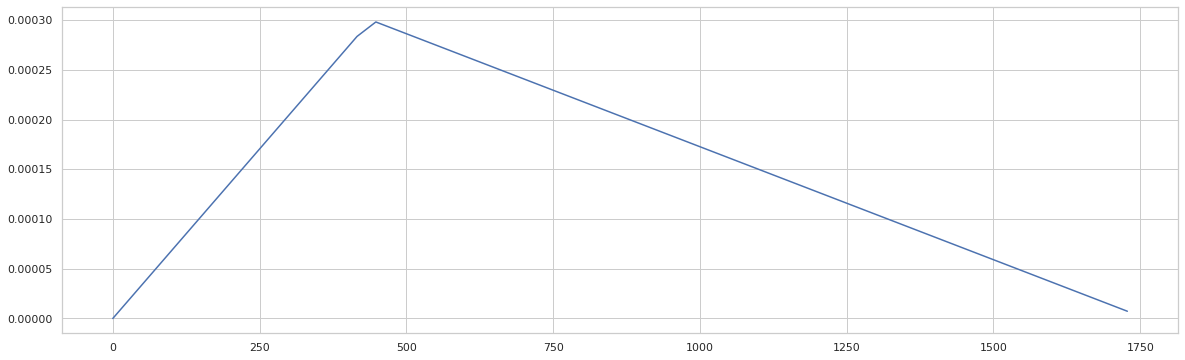

In [ ]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, 32)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [ ]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)

    # multi-sample dropout
    samples = []
    sample_mask = L.Dense(512, activation='relu')
    for n in range(16): # 16 samples
        sample = L.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = L.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    output = L.Average(name='output')(samples)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [ ]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.93.157.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.157.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 40s - loss: 0.5628 - auc: 0.5741 - val_loss: 0.3513 - val_auc: 0.5990
Epoch 2/20
93/93 - 25s - loss: 0.2846 - auc: 0.8677 - val_loss: 0.3054 - val_auc: 0.8182
Epoch 3/20
93/93 - 25s - loss: 0.2643 - auc: 0.8996 - val_loss: 0.2904 - val_auc: 0.8695
Epoch 4/20
93/93 - 26s - loss: 0.2518 - auc: 0.9154 - val_loss: 0.2612 - val_auc: 0.9045
Epoch 5/20
93/93 - 25s - loss: 0.2420 - auc: 0.9294 - val_loss: 0.2427 - val_auc: 0.9217
Epoch 6/20
93/93 - 25s - loss: 0.2331 - auc: 0.9386 - val_loss: 0.2323 - val_auc: 0.9329
Epoch 7/20
93/93 - 25s - loss: 0.2234 - auc: 0.9464 - val_loss: 0.2250 - val_auc: 0.9437
Epoch 8/20
93/93 - 25s - loss: 0.2154 - auc: 0.9542 - val_loss: 0.2211 - val_auc: 0.9415
Epoch 9/20
93/93 - 25s - loss: 0.2070 - auc: 0.9602 - val_loss: 0.2168 - val_auc: 0.9469
Epoch 10/20
93/93 - 25s - loss: 0.2013 - auc: 0.9645 - val_loss: 0.2153 - val_auc: 0.9423
Epoch 11/20
93/93 - 23s - loss: 0.1960 - auc: 0.9684 - val_loss: 0.2164 - val_auc: 0.9527
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.93.157.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.157.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 40s - loss: 0.5652 - auc: 0.5767 - val_loss: 0.3530 - val_auc: 0.6190
Epoch 2/20
93/93 - 25s - loss: 0.2850 - auc: 0.8657 - val_loss: 0.3189 - val_auc: 0.7757
Epoch 3/20
93/93 - 25s - loss: 0.2635 - auc: 0.9010 - val_loss: 0.2888 - val_auc: 0.8553
Epoch 4/20
93/93 - 25s - loss: 0.2536 - auc: 0.9129 - val_loss: 0.2605 - val_auc: 0.9117
Epoch 5/20
93/93 - 25s - loss: 0.2426 - auc: 0.9247 - val_loss: 0.2455 - val_auc: 0.9273
Epoch 6/20
93/93 - 25s - loss: 0.2336 - auc: 0.9368 - val_loss: 0.2403 - val_auc: 0.9373
Epoch 7/20
93/93 - 25s - loss: 0.2239 - auc: 0.9463 - val_loss: 0.2348 - val_auc: 0.9457
Epoch 8/20
93/93 - 25s - loss: 0.2160 - auc: 0.9529 - val_loss: 0.2281 - val_auc: 0.9514
Epoch 9/20
93/93 - 25s - loss: 0.2090 - auc: 0.9590 - val_loss: 0.2216 - val_auc: 0.9485
Epoch 10/20
93/93 - 25s - loss: 0.2007 - auc: 0.9654 - val_loss: 0.2144 - val_auc: 0.9551
Epoch 11/20
93/93 - 23s - loss: 0.1965 - auc: 0.9693 - val_loss: 0.2147 - val_auc: 0.9535
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.93.157.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.157.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
97/97 - 39s - loss: 0.5346 - auc: 0.5773 - val_loss: 0.3566 - val_auc: 0.6344
Epoch 2/20
97/97 - 26s - loss: 0.2785 - auc: 0.8778 - val_loss: 0.3215 - val_auc: 0.7833
Epoch 3/20
97/97 - 26s - loss: 0.2610 - auc: 0.9033 - val_loss: 0.2814 - val_auc: 0.8696
Epoch 4/20
97/97 - 26s - loss: 0.2474 - auc: 0.9206 - val_loss: 0.2540 - val_auc: 0.9210
Epoch 5/20
97/97 - 26s - loss: 0.2387 - auc: 0.9304 - val_loss: 0.2414 - val_auc: 0.9355
Epoch 6/20
97/97 - 26s - loss: 0.2304 - auc: 0.9392 - val_loss: 0.2366 - val_auc: 0.9392
Epoch 7/20
97/97 - 24s - loss: 0.2203 - auc: 0.9495 - val_loss: 0.2381 - val_auc: 0.9344
Epoch 8/20
97/97 - 24s - loss: 0.2122 - auc: 0.9575 - val_loss: 0.2374 - val_auc: 0.9374
Epoch 9/20
97/97 - 26s - loss: 0.2050 - auc: 0.9625 - val_loss: 0.2364 - val_auc: 0.9335
Epoch 10/20
97/97 - 26s - loss: 0.1964 - auc: 0.9665 - val_loss: 0.2315 - val_auc: 0.9465
Epoch 11/20
97/97 - 26s - loss: 0.1914 - auc: 0.9719 - val_loss: 0.2278 - val_auc: 0.9444
Epoch 12/20
97/97 -

## Model loss graph

Fold: 1


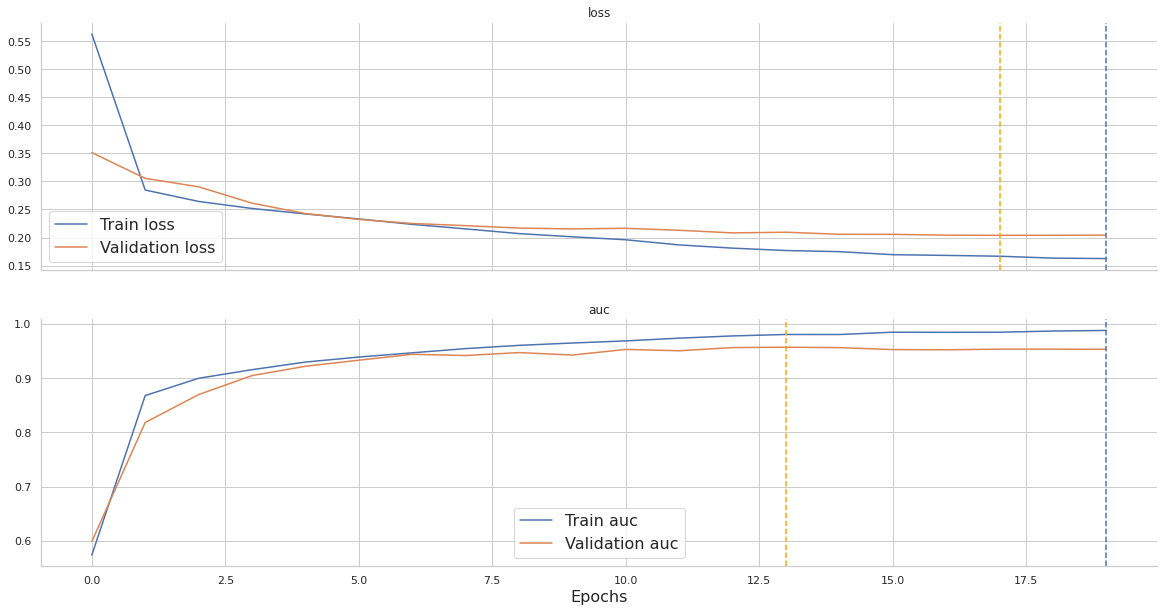

Fold: 2


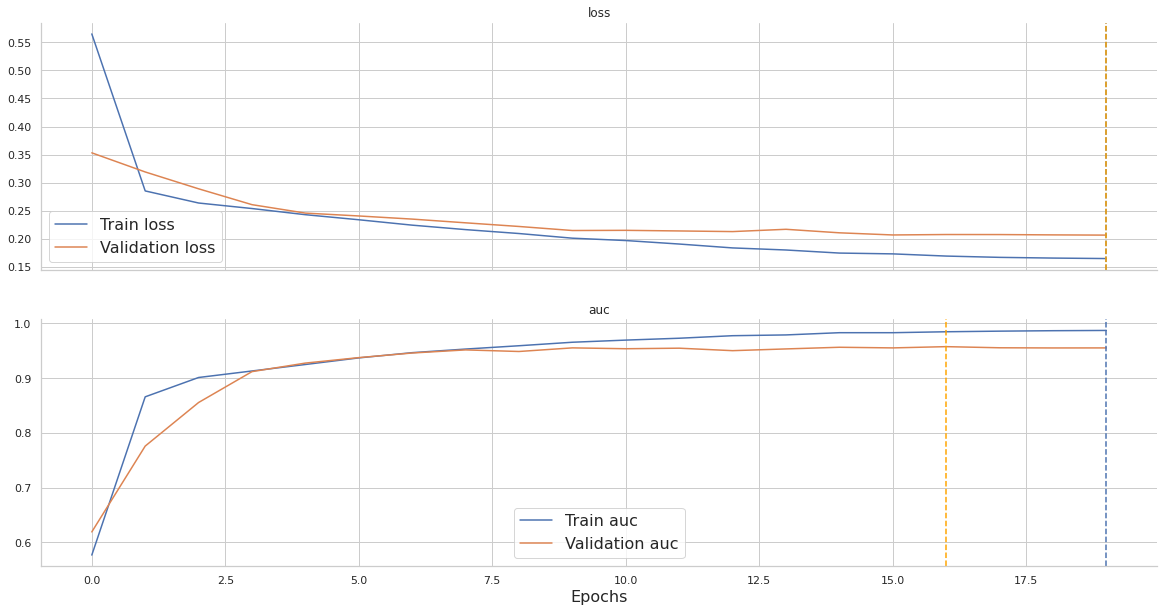

Fold: 3


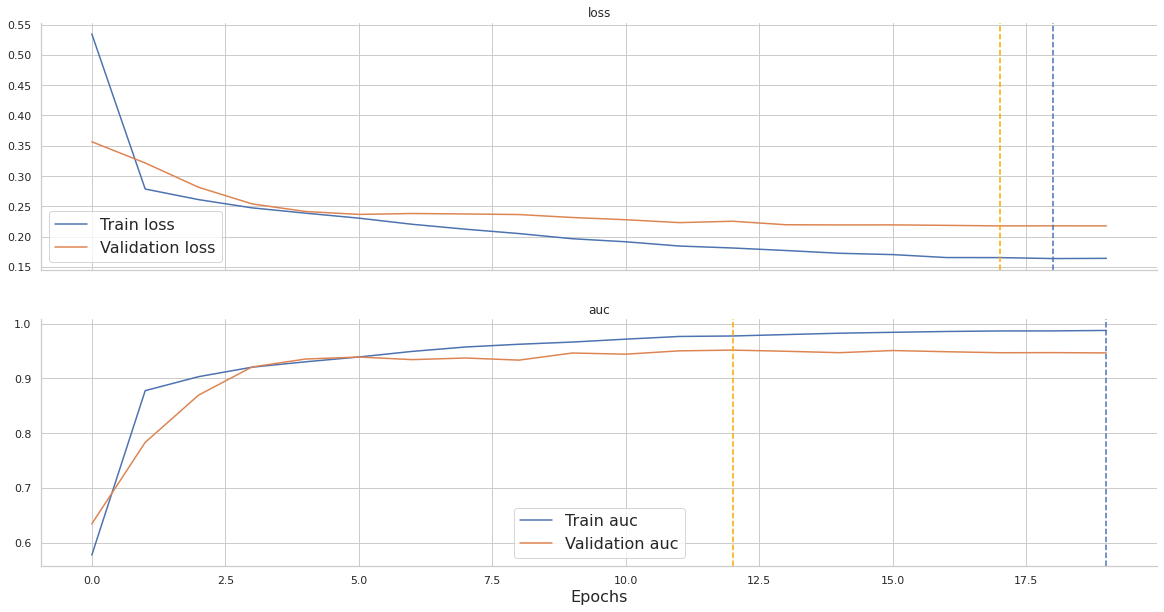

In [ ]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

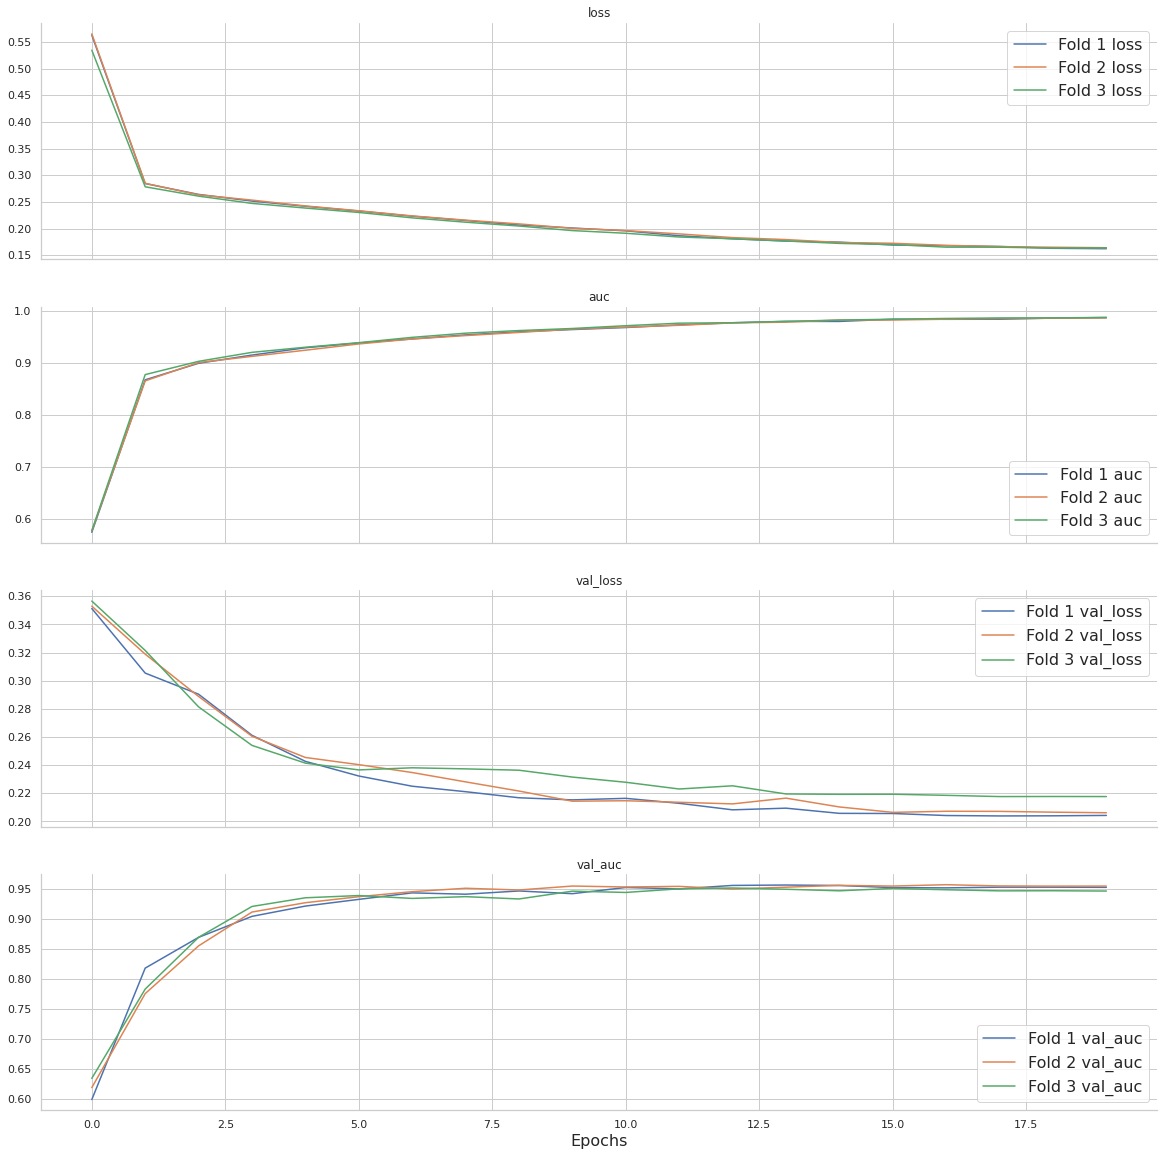

In [ ]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [ ]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.981419,0.875796,0.105622,0.978859,0.883698,0.984140,0.886440,0.981256,0.857252
Accuracy,0.993552,0.981285,0.012267,0.993480,0.983694,0.993089,0.981001,0.994086,0.979160
Precision,0.919581,0.449766,0.469815,0.922438,0.476190,0.891061,0.452055,0.945245,0.421053
Recall,0.695487,0.253797,0.441690,0.698113,0.280374,0.690476,0.270492,0.697872,0.210526
F1-score,0.791912,0.324035,0.467877,0.794749,0.352941,0.778049,0.338462,0.802938,0.280702
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [ ]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.981419,0.875796,0.105622,0.978859,0.883698,0.984140,0.886440,0.981256,0.857252
male,0.984904,0.888180,0.096724,0.981743,0.901225,0.986547,0.913568,0.986421,0.849747
female,0.975816,0.852090,0.123726,0.974009,0.851107,0.979793,0.830041,0.973646,0.875122
head/neck,0.995383,0.857673,0.137711,0.993793,0.952458,0.994958,0.860885,0.997399,0.759675
upper extremity,0.979693,0.919417,0.060277,0.975886,0.909552,0.981894,0.916710,0.981300,0.931988
lower extremity,0.969721,0.785935,0.183786,0.965728,0.800675,0.980027,0.760483,0.963408,0.796646
torso,0.984227,0.904792,0.079435,0.982909,0.886262,0.984746,0.927329,0.985025,0.900784
0 <= age < 26,0.964815,0.797819,0.166996,0.960289,0.851630,0.979839,0.761270,0.954316,0.780556
26 <= age < 40,0.974731,0.841991,0.132739,0.978842,0.728561,0.977827,0.850316,0.967523,0.947097


# Model evaluation (best)

In [ ]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.981341,0.873970,0.107371,0.978866,0.883078,0.984173,0.886409,0.980983,0.852422
Accuracy,0.993439,0.981377,0.012062,0.993290,0.984139,0.993051,0.981001,0.993976,0.978990
Precision,0.917274,0.454256,0.463017,0.916667,0.500000,0.892958,0.452055,0.942197,0.410714
Recall,0.690529,0.244643,0.445887,0.691824,0.261682,0.686147,0.270492,0.693617,0.201754
F1-score,0.787853,0.317536,0.470317,0.788530,0.343558,0.776010,0.338462,0.799020,0.270588
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.981341,0.873970,0.107371,0.978866,0.883078,0.984173,0.886409,0.980983,0.852422
male,0.984895,0.886155,0.098740,0.981904,0.901561,0.986567,0.912647,0.986214,0.844257
female,0.975594,0.851378,0.124216,0.973727,0.848993,0.979820,0.832016,0.973233,0.873124
head/neck,0.995348,0.851064,0.144284,0.993793,0.950846,0.994946,0.861247,0.997304,0.741099
upper extremity,0.979866,0.919240,0.060626,0.975897,0.910474,0.981933,0.916667,0.981767,0.930578
lower extremity,0.969413,0.785891,0.183521,0.966167,0.806635,0.979750,0.761377,0.962321,0.789662
torso,0.984160,0.903155,0.081005,0.982746,0.882930,0.984957,0.926171,0.984779,0.900365
0 <= age < 26,0.963190,0.795887,0.167302,0.955011,0.846739,0.980021,0.759904,0.954538,0.781019
26 <= age < 40,0.974321,0.837324,0.136997,0.978541,0.716085,0.977649,0.849447,0.966774,0.946440


# Confusion matrix

Fold: 1


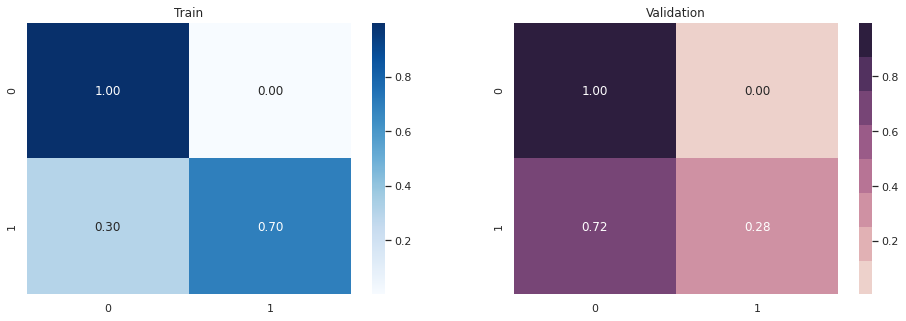

Fold: 2


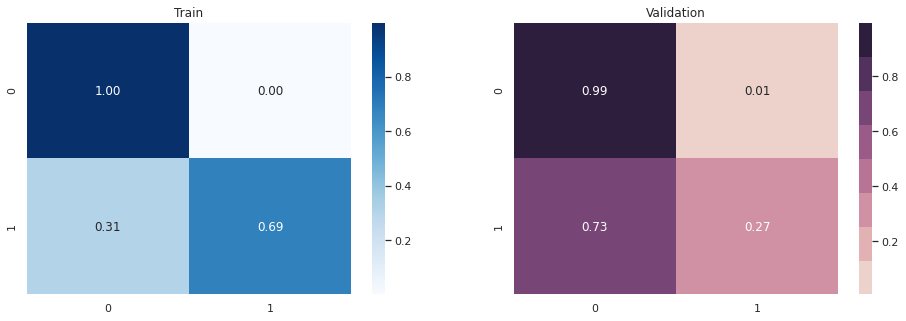

Fold: 3


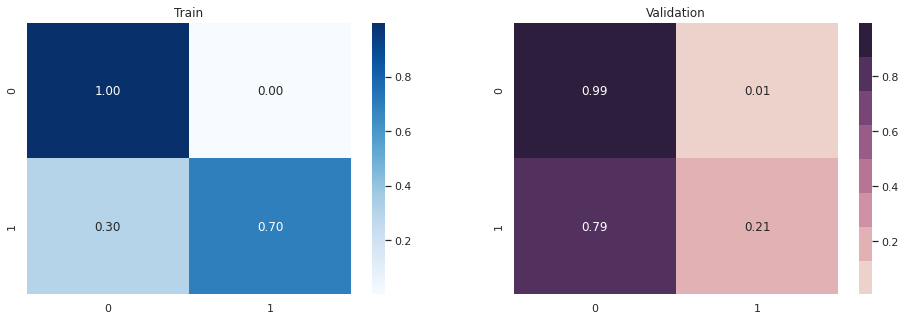

In [ ]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [ ]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 190
Train positive correct predictions: 188
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.016187,0.024418,0.027706,0.028808
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.017789,0.027866,0.030131,0.030949
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.017339,0.030314,0.029093,0.027287
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.016812,0.023308,0.029474,0.031277
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.015501,0.025839,0.027179,0.024488
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.015798,0.025380,0.025872,0.027740
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.019306,0.035871,0.026961,0.033701
7,ISIC_0075663,female,35.0,torso,unknown,0,0.016760,0.031160,0.027853,0.024788
8,ISIC_0075914,male,30.0,torso,unknown,0,0.016395,0.025609,0.028866,0.027502
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.017766,0.028739,0.032365,0.027726


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.017445,0.026231,0.030918,0.030079
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.325712,0.844578,0.094825,0.689157
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.356378,0.799405,0.035684,0.946799
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.310758,0.637873,0.058799,0.857118
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.525942,0.917615,0.768910,0.943187
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.509732,0.626982,0.960473,0.961205
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.277410,0.035190,0.508088,0.843773
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.467140,0.910637,0.615762,0.809303
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.251841,0.057653,0.625041,0.576509
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.144893,0.653401,0.037595,0.033468


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.525942,0.917615,0.768910,0.943187
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.509732,0.626982,0.960473,0.961205
747,ISIC_0327406,male,40.0,upper extremity,melanoma,1,0.500740,0.812592,0.877259,0.813849
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.574708,0.966757,0.947855,0.958927
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.565960,0.956364,0.929509,0.943926
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.583483,0.981404,0.988544,0.947469
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.562975,0.922957,0.965500,0.926420
1435,ISIC_0533122,male,75.0,lower extremity,melanoma,1,0.555417,0.929567,0.917833,0.929684
1742,ISIC_0624498,female,80.0,torso,melanoma,1,0.591806,0.983200,0.986968,0.988860
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.595695,0.993106,0.993047,0.992321


# Visualize test predictions

In [ ]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 127|10855
Test predictions (last) 130|10852
Test predictions (tta) 114|10868
Test predictions (last tta) 121|10861
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.025277,0.024784,0.026381,0.025745
1,ISIC_0052349,male,40.0,lower extremity,0.028152,0.027666,0.026745,0.026134
2,ISIC_0058510,female,55.0,torso,0.027847,0.027292,0.026099,0.025441
3,ISIC_0073313,female,50.0,torso,0.026473,0.025910,0.026306,0.025698
4,ISIC_0073502,female,45.0,lower extremity,0.028323,0.027601,0.026988,0.026657
5,ISIC_0074618,male,50.0,lower extremity,0.026739,0.026394,0.030280,0.028219
6,ISIC_0076801,male,45.0,upper extremity,0.027867,0.027389,0.029214,0.028587
7,ISIC_0077586,male,50.0,lower extremity,0.047091,0.047668,0.124946,0.131870
8,ISIC_0082004,female,45.0,torso,0.027964,0.027509,0.027743,0.027012
9,ISIC_0082785,male,65.0,lower extremity,0.027626,0.027054,0.027947,0.027606


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
102,ISIC_0208233,female,60.0,lower extremity,0.970858,0.971030,0.814114,0.770152
255,ISIC_0351156,male,40.0,head/neck,0.841198,0.843838,0.430153,0.413143
296,ISIC_0391046,male,85.0,torso,0.676169,0.673833,0.680696,0.606724
355,ISIC_0446097,male,40.0,torso,0.522478,0.520751,0.448014,0.461104
403,ISIC_0481105,male,80.0,torso,0.954193,0.957626,0.956096,0.960782
453,ISIC_0524466,female,30.0,head/neck,0.577983,0.577674,0.325167,0.373644
471,ISIC_0539432,female,45.0,lower extremity,0.967398,0.968286,0.971203,0.973611
552,ISIC_0606244,male,70.0,torso,0.968076,0.969172,0.886537,0.910041
596,ISIC_0637104,female,80.0,torso,0.524564,0.525920,0.550432,0.522733
727,ISIC_0740997,male,40.0,torso,0.591759,0.605340,0.278233,0.229135


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
102,ISIC_0208233,female,60.0,lower extremity,0.970858,0.971030,0.814114,0.770152
255,ISIC_0351156,male,40.0,head/neck,0.841198,0.843838,0.430153,0.413143
296,ISIC_0391046,male,85.0,torso,0.676169,0.673833,0.680696,0.606724
355,ISIC_0446097,male,40.0,torso,0.522478,0.520751,0.448014,0.461104
403,ISIC_0481105,male,80.0,torso,0.954193,0.957626,0.956096,0.960782
453,ISIC_0524466,female,30.0,head/neck,0.577983,0.577674,0.325167,0.373644
471,ISIC_0539432,female,45.0,lower extremity,0.967398,0.968286,0.971203,0.973611
552,ISIC_0606244,male,70.0,torso,0.968076,0.969172,0.886537,0.910041
596,ISIC_0637104,female,80.0,torso,0.524564,0.525920,0.550432,0.522733
727,ISIC_0740997,male,40.0,torso,0.591759,0.605340,0.278233,0.229135


# Test set predictions

In [ ]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.025277,0.024784,0.025030,0.026381,0.025745,0.026063
1,ISIC_0052349,0.028152,0.027666,0.027909,0.026745,0.026134,0.026440
2,ISIC_0058510,0.027847,0.027292,0.027570,0.026099,0.025441,0.025770
3,ISIC_0073313,0.026473,0.025910,0.026191,0.026306,0.025698,0.026002
4,ISIC_0073502,0.028323,0.027601,0.027962,0.026988,0.026657,0.026823
5,ISIC_0074618,0.026739,0.026394,0.026567,0.030280,0.028219,0.029250
6,ISIC_0076801,0.027867,0.027389,0.027628,0.029214,0.028587,0.028900
7,ISIC_0077586,0.047091,0.047668,0.047380,0.124946,0.131870,0.128408
8,ISIC_0082004,0.027964,0.027509,0.027736,0.027743,0.027012,0.027377
9,ISIC_0082785,0.027626,0.027054,0.027340,0.027947,0.027606,0.027777


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.047116,0.046558,0.046837,0.048001,0.047511,0.047756
std,0.089923,0.090295,0.090091,0.086519,0.086882,0.086618
min,0.021178,0.020840,0.021009,0.022387,0.022001,0.022407
25%,0.027327,0.026810,0.027071,0.027532,0.026993,0.027260
50%,0.029183,0.028661,0.028932,0.029768,0.029245,0.029505
75%,0.033258,0.032632,0.032933,0.034704,0.034146,0.034440
max,0.991800,0.991555,0.991678,0.994257,0.993982,0.994120
